# Cell clustering notebook

Note: this notebook should be run after `example_pixel_clustering.ipynb` in the same Docker session

In [ ]:
# import required packages
from datetime import datetime as dt
import os
import subprocess

import feather
import numpy as np
import pandas as pd
import xarray as xr

from ark.phenotyping import som_utils
from ark.utils import data_utils, io_utils, load_utils, plot_utils

### Set file paths and parameters

Note: these should be the same as in `example_pixel_clustering.ipynb`

* `base_dir`: the path to all of your imaging data. Should contain a directory for your images, segmentations, and cell table (generated from Segment_Image_Data.ipynb).
* `tiff_dir`: the path to the directory containing your imaging data
* `segmentation_dir`: the path to the directory containing your segmentations (generated from Segment_Image_Data.ipynb)

In [ ]:
base_dir = "../data/granulomaCohort_allData"
tiff_dir = os.path.join(base_dir, "TIFs")
segmentation_dir = "../data/granulomaCohort_allData"

* `pixel_consensus_dir`: the name of the directory containing pixel data with the pixel SOM and consensus cluster assignments, taken from the consensus dir used in `example_pixel_clustering.ipynb`

In [ ]:
%store -r pixel_consensus_dir

* `cell_table_name`: name of the cell table created by `Segment_Image_Data.ipynb`, should be placed in the root of `base_dir`. You can use either the normalized or arcsinh versions.

In [ ]:
cell_table_name = 'cell_table_size_normalized.csv'

* `MIBItiff`: if the images in tiff_dir are mibitiff or not
* `mibitiff_suffix` (required if MIBItiff is True): the file suffix all mibitiff images contain

In [ ]:
MIBItiff = False
mibitiff_suffix = '-MassCorrected-Filtered.tiff'

* `fovs`: the set of fovs to load, taken from list specified in `example_pixel_clustering.ipynb`

In [ ]:
%store -r fovs

* `channels`: a subset of markers, taken from list specified in `example_pixel_clustering.ipynb`

In [ ]:
%store -r channels

### Train cell SOM

Set a prefix to be applied to all data directories/files created by pixel and cell clustering. If the prefix is not set, a default of the datetime at the start of the run is used. The following data directories/files will be created for pixel clustering:

* `{cluster_prefix}_cell_clustered_name`: file to store cell data with just the SOM cluster assignments
* `{cluster_prefix}_cell_consensus_dir`: directory to store cell data with the SOM and consensus cluster assignments
* `{cluster_prefix}_cell_weights_name`: file name to place the cell SOM weights

In [ ]:
# explicitly set cluster_prefix to override datetime default
cluster_prefix = None

if cluster_prefix is None:
    cluster_prefix = dt.now().strftime('%Y-%m-%dT%H:%M:%S')

In [ ]:
# define the cell SOM cluster and cell SOM weights paths, explicitly set the variables to use custom names
cell_clustered_name = '%s_cell_mat_clustered.feather' % cluster_prefix
cell_consensus_name = '%s_cell_mat_consensus.feather' % cluster_prefix
cell_weights_name = '%s_cell_weights.feather' % cluster_prefix

* `cluster_col`: whether to use pixel SOM or meta cluster counts for training. Set to 'cluster' or 'hCluster_cap' respectively

In [ ]:
cluster_col = 'hCluster_cap'

For a full set of parameters you can customize for train_cell_som, please consult: https://ark-analysis.readthedocs.io/en/latest/_markdown/ark.phenotyping.html#ark.phenotyping.som_utils.train_cell_som

In [ ]:
# create the cell-level SOM weights
som_utils.train_cell_som(
    fovs,
    base_dir,
    cell_table_name=cell_table_name,
    pixel_consensus_dir=pixel_consensus_dir,
    weights_name=cell_weights_name,
    cluster_col=cluster_col,
    num_passes=10
)

### Assign cell SOM clusters

In [ ]:
# use cell SOM weights to assign cell clusters
som_utils.cluster_cells(
    base_dir,
    weights_name=cell_weights_name,
    cell_cluster_name=cell_clustered_name
)

### Visualize the number of cells per SOM cluster

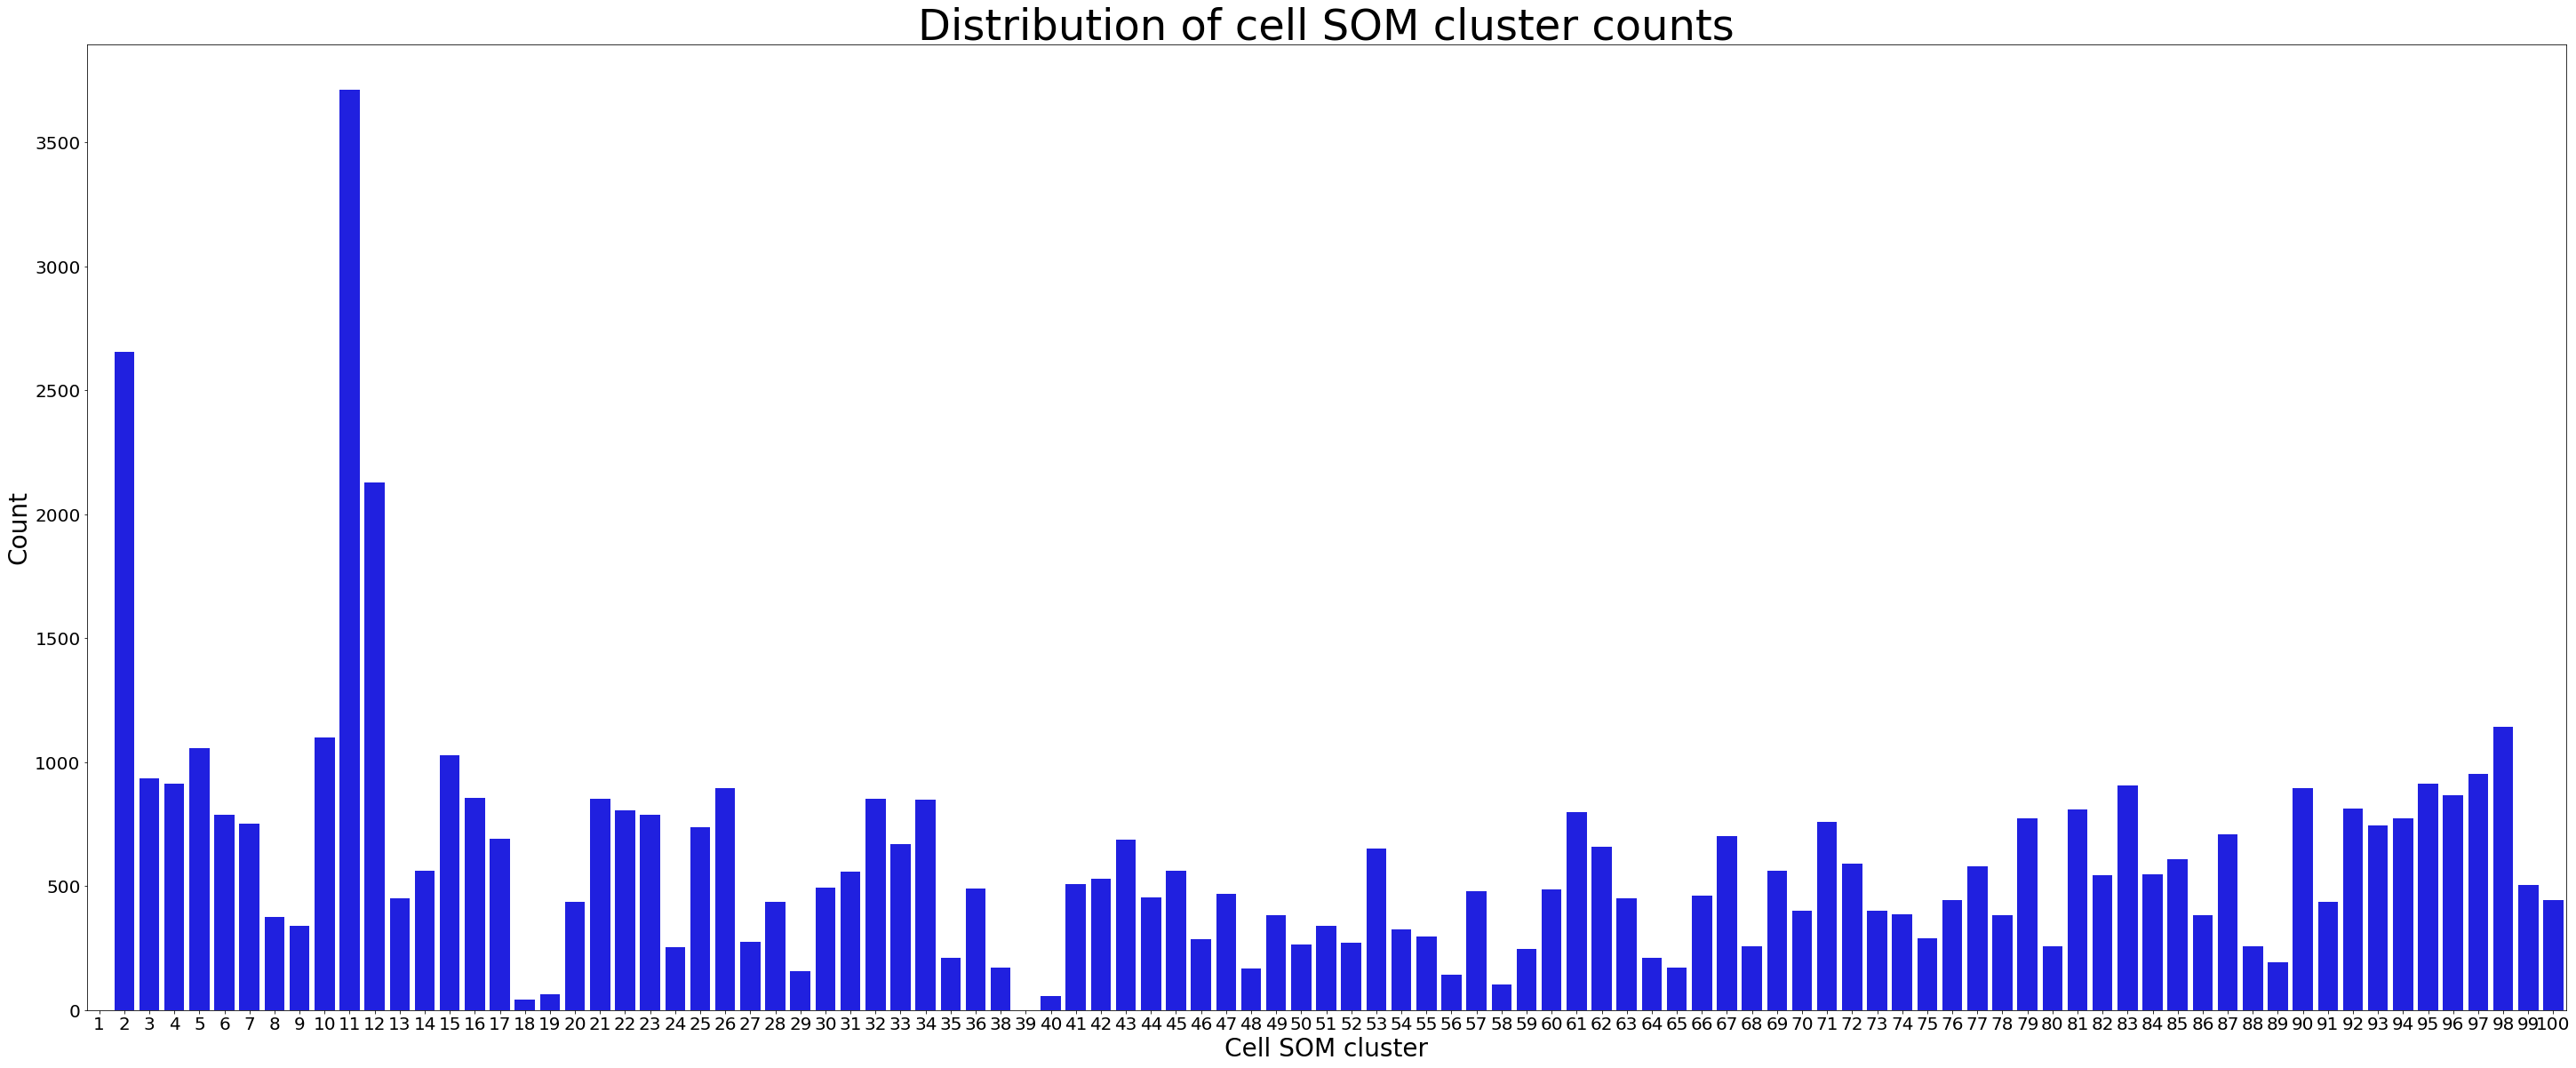

In [13]:
som_utils.visualize_cell_cluster_counts(
    base_dir,
    cell_clustered_name,
    column_prefix=cluster_col,
    cell_cluster_col='cluster'
)

### Visualize the weighted cell SOM cluster average heatmap over channels (z-scored)

* See documentation of `compute_p2c_weighted_channel_avg` for how weighted cell channel average is computed: (insert link here)
* The weighted cell channel average result will also be used for interactive reclustering
* Results are also saved as `cell_channel_avg_cluster.feather` and `cell_channel_avg_hCluster_cap` in `base_dir`

In [ ]:
# recall pixel cluster channel averages from example_pixel_clustering.ipynb
%store -r pixel_cluster_channel_avg_cluster
%store -r pixel_cluster_channel_avg_hCluster_cap

In [ ]:
# compute number of pixel SOM clusters per cell
pixel_cluster_counts_per_cell = som_utils.compute_cell_cluster_counts(
    fovs, os.path.join(base_dir, pixel_consensus_dir), os.path.join(base_dir, cell_table_name), cluster_col='cluster'
)

# compute number of pixel meta clusters per cell
pixel_hCluster_cap_counts_per_cell = som_utils.compute_cell_cluster_counts(
    fovs, os.path.join(base_dir, pixel_consensus_dir), os.path.join(base_dir, cell_table_name), cluster_col='hCluster_cap'
)

In [ ]:
# compute the weighted channel average per cell (based on pixel SOM cluster counts)
cell_channel_avg_cluster = som_utils.compute_p2c_weighted_channel_avg(
    pixel_cluster_channel_avg_cluster, pixel_cluster_counts_per_cell, fovs=fovs, cluster_col='cluster'
)

# compute the weighted channel average per cell (based on pixel meta cluster counts)
cell_channel_avg_hCluster_cap = som_utils.compute_p2c_weighted_channel_avg(
    pixel_cluster_channel_avg_hCluster_cap, pixel_hCluster_cap_counts_per_cell, fovs=fovs, cluster_col='hCluster_cap'
)

In [ ]:
# NOTE: I will remove these lines after this is ready to merge in
cell_channel_avg_cluster = cell_channel_avg_cluster[cell_channel_avg_cluster['segmentation_label'] != 1]
cell_channel_avg_hCluster_cap = cell_channel_avg_hCluster_cap[cell_channel_avg_hCluster_cap['segmentation_label'] != 1]

In [ ]:
# save cell_channel_avg_cluster and cell_channel_avg_hCluster_cap
feather.write_dataframe(
    cell_channel_avg_cluster, os.path.join(base_dir, 'cell_channel_avg_cluster.feather')
)

feather.write_dataframe(
    cell_channel_avg_hCluster_cap, os.path.join(base_dir, 'cell_channel_avg_hCluster_cap.feather')
)

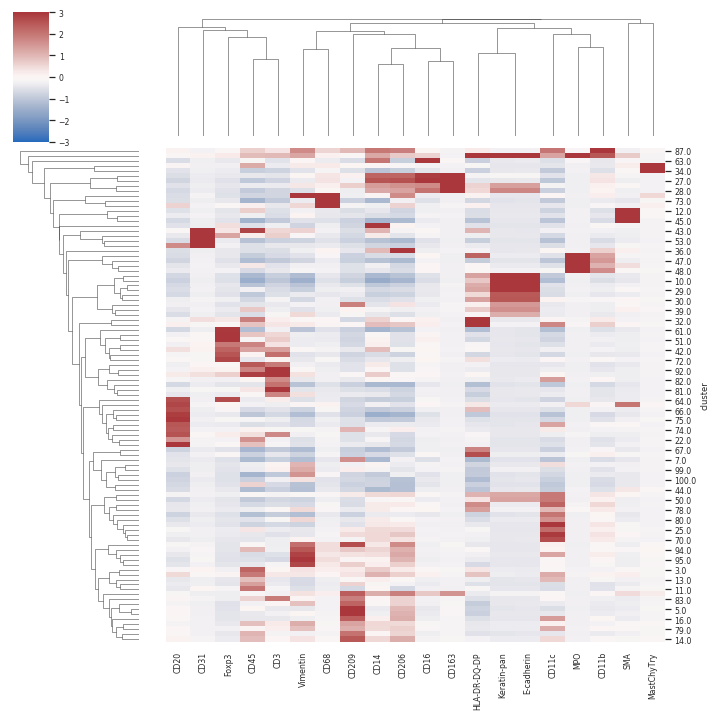

In [19]:
# visualize the cell SOM cluster weighted average heatmap over channels (z-scored)
# CANDACE SUGGESTION: change to weighted channel expression rather than base channel expression
# make sure to add a comment explaining why that is the case, it's more discrete since we take advantage of pixel cluster info
som_utils.visualize_cell_cluster_channel_avg(
    fovs,
    channels,
    base_dir,
    os.path.join(base_dir, 'cell_channel_avg_%s.feather' % cluster_col),
    cell_clustered_name,
    'cluster',
    center_val=0,
    min_val=-3,
    max_val=3,
    cbar_ticks=np.arange(-3, 4)
)

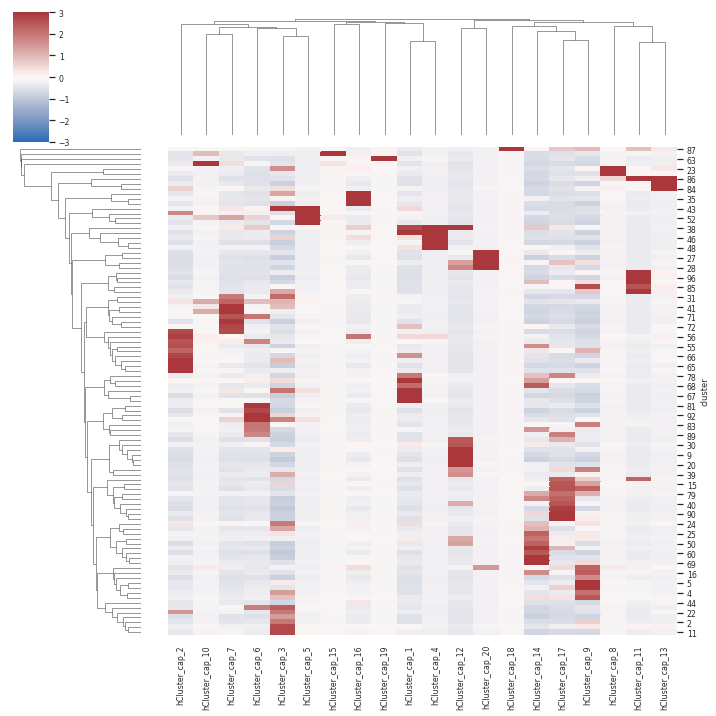

In [20]:
# visualize the average number of pixel clusters per cell SOM cluster (z-scored)
som_utils.visualize_avg_p2c_counts(
    base_dir,
    cluster_name=cell_clustered_name,
    column_prefix=cluster_col,
    cell_cluster_col='cluster',
    center_val=0,
    min_val=-3,
    max_val=3,
    cbar_ticks=np.arange(-3, 4)
)

### Run cell consensus clustering

For a full set of parameters you can customize for cell_consensus_cluster, please consult: https://ark-analysis.readthedocs.io/en/latest/_markdown/ark.phenotyping.html#ark.phenotyping.som_utils.cell_consensus_cluster

In [ ]:
# run hierarchical clustering based on cell SOM cluster assignments
som_utils.cell_consensus_cluster(
    base_dir=base_dir,
    cell_cluster_name=cell_clustered_name,
    column_prefix=cluster_col,
    cell_consensus_name=cell_consensus_name
)

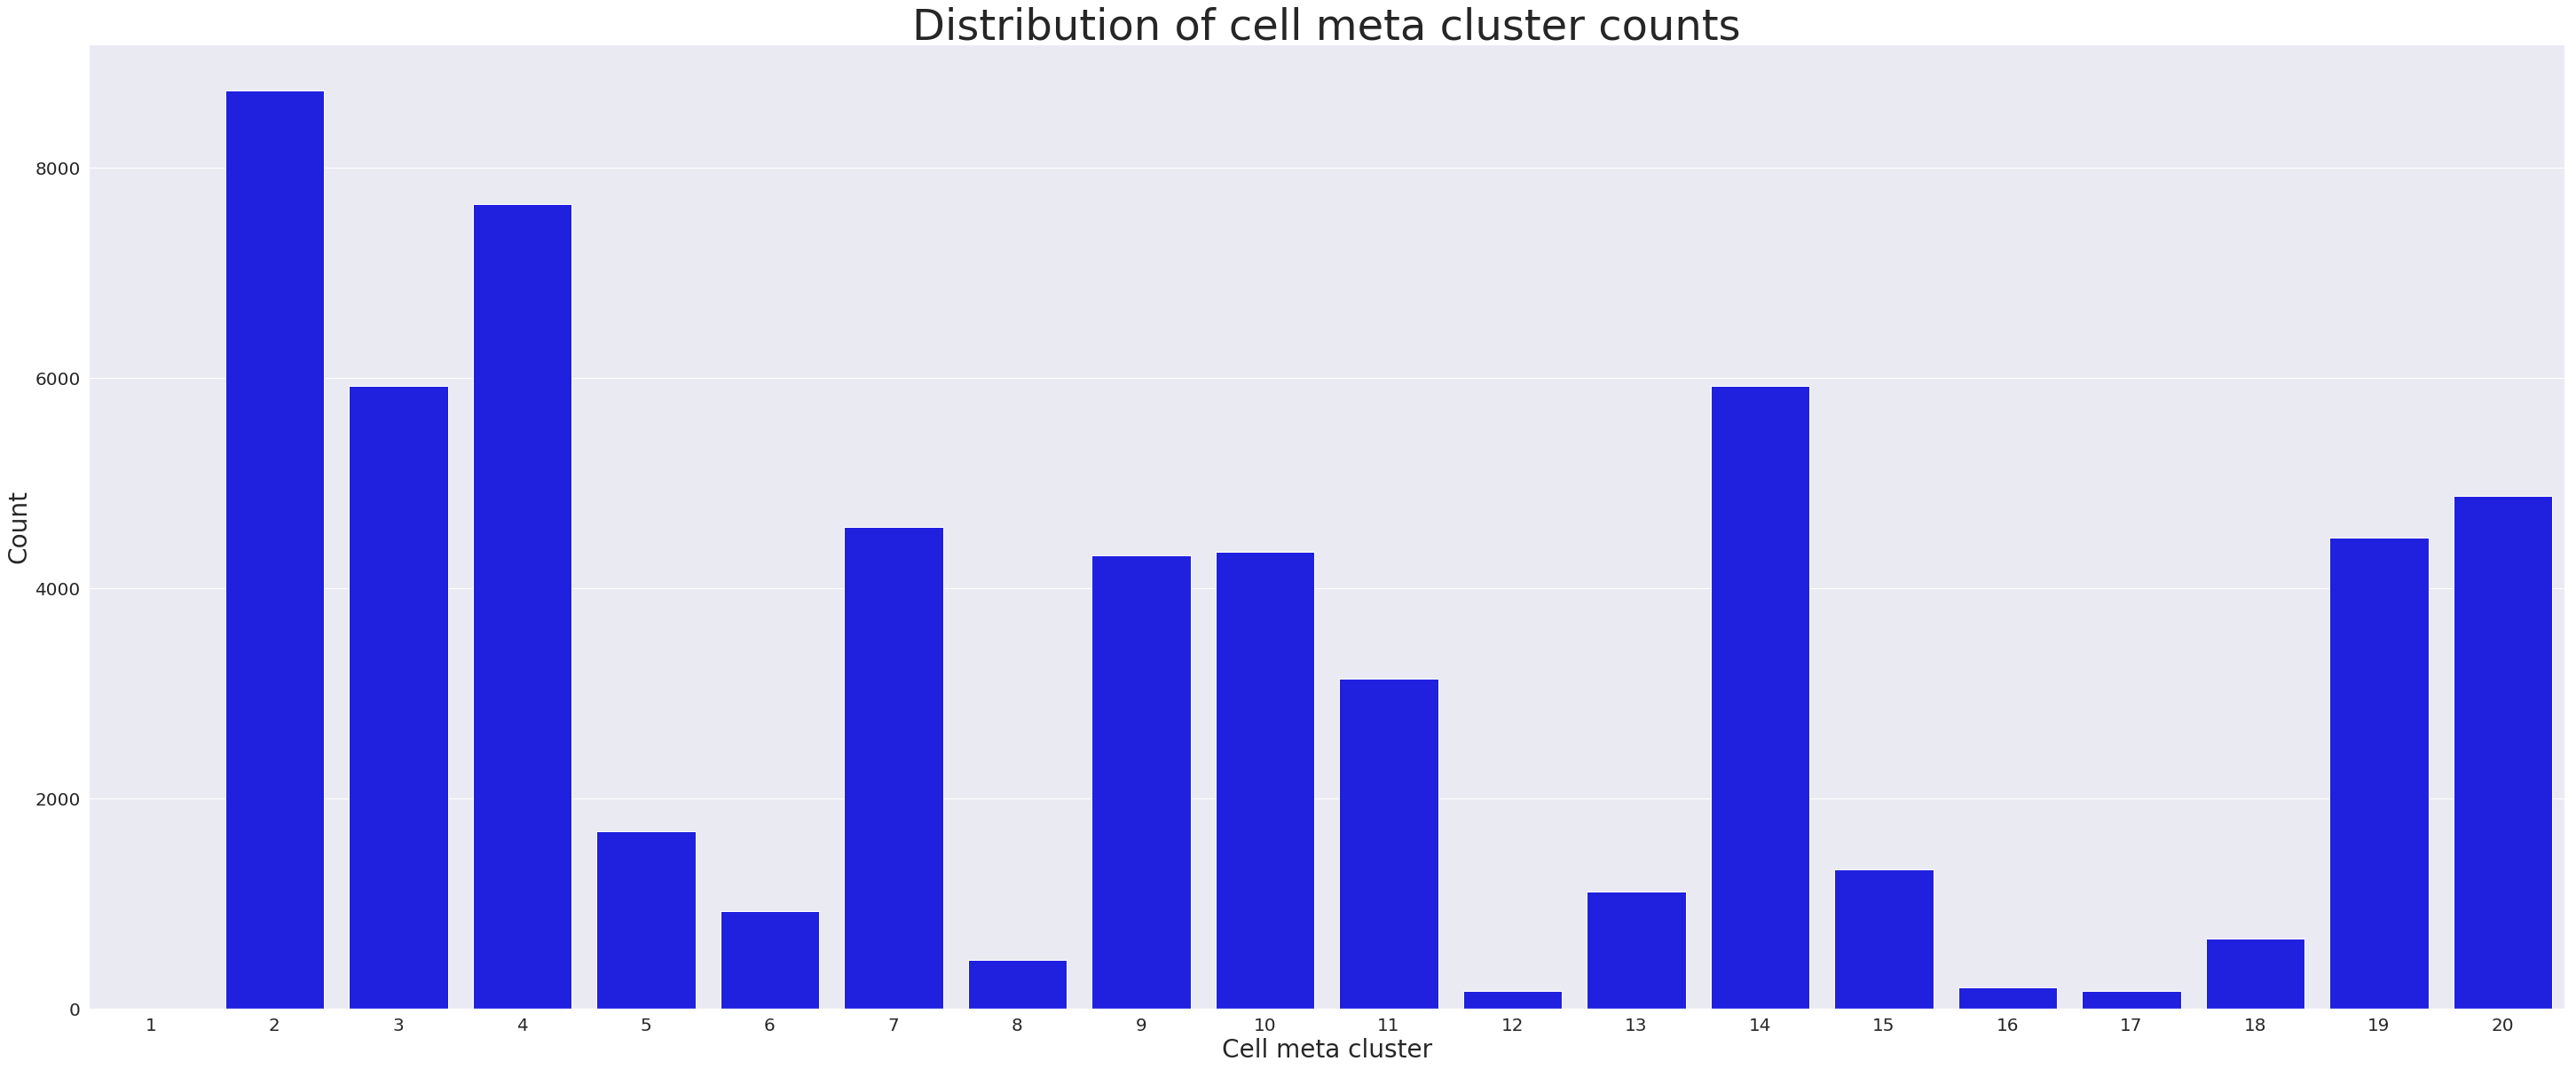

In [22]:
# visualize the number of cells per meta cluster
som_utils.visualize_cell_cluster_counts(
    base_dir,
    cell_consensus_name,
    column_prefix=cluster_col,
    cell_cluster_col='hCluster_cap'
)

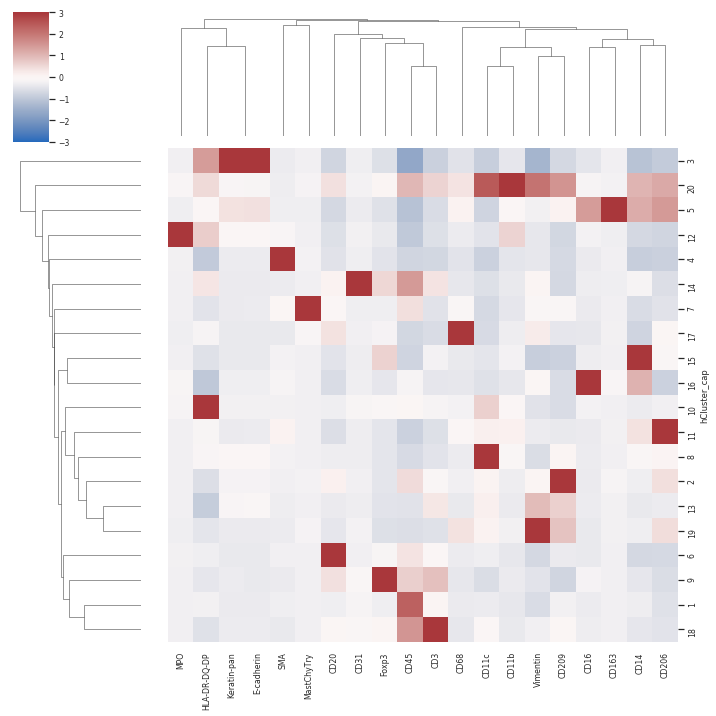

In [23]:
# visualize the cell meta cluster weighted average heatmap over channels (z-scored)
# CANDACE SUGGESTION: change to weighted channel expression rather than base channel expression
# make sure to add a comment explaining why that is the case, it's more discrete since we take advantage of pixel cluster info
som_utils.visualize_cell_cluster_channel_avg(
    fovs,
    channels,
    base_dir,
    os.path.join(base_dir, 'cell_channel_avg_%s.feather' % cluster_col),
    cell_consensus_name,
    'hCluster_cap',
    center_val=0,
    min_val=-3,
    max_val=3,
    cbar_ticks=np.arange(-3, 4)
)

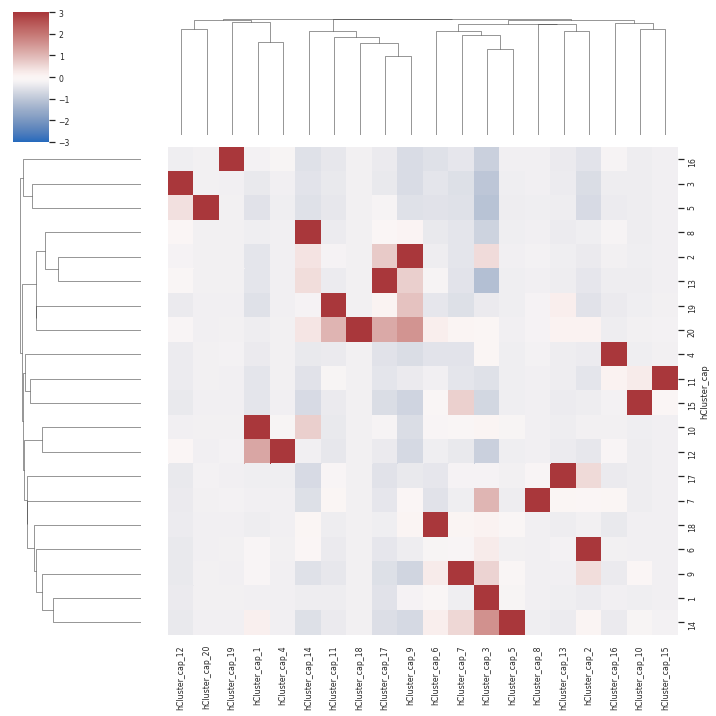

In [24]:
# visualize the average number of pixel clusters per cell meta cluster (z-scored)
som_utils.visualize_avg_p2c_counts(
    base_dir,
    cluster_name=cell_consensus_name,
    column_prefix=cluster_col,
    cell_cluster_col='hCluster_cap',
    center_val=0,
    min_val=-3,
    max_val=3,
    cbar_ticks=np.arange(-3, 4)
)

### Visualize cell cluster overlay

In [ ]:
# select fovs to display
cell_fovs = ['fov6', 'fov7']

In [ ]:
# generate the cell cluster masks for each fov in cell_fovs
cell_cluster_masks = data_utils.generate_cell_cluster_mask(
    cell_fovs,
    base_dir,
    segmentation_dir,
    cell_consensus_name=cell_consensus_name,
    cluster_col='hCluster_cap'
)

* `save_pixel_masks`: replace with True if you want to save, files will be written as `{fov_name}_cell_mask.tiff` in `base_dir`

In [ ]:
save_cell_masks = False

if save_cell_masks:
    data_utils.save_fov_images(
        cell_fovs,
        base_dir,
        cell_cluster_masks,
        name_suffix='_cell_mask'
    )

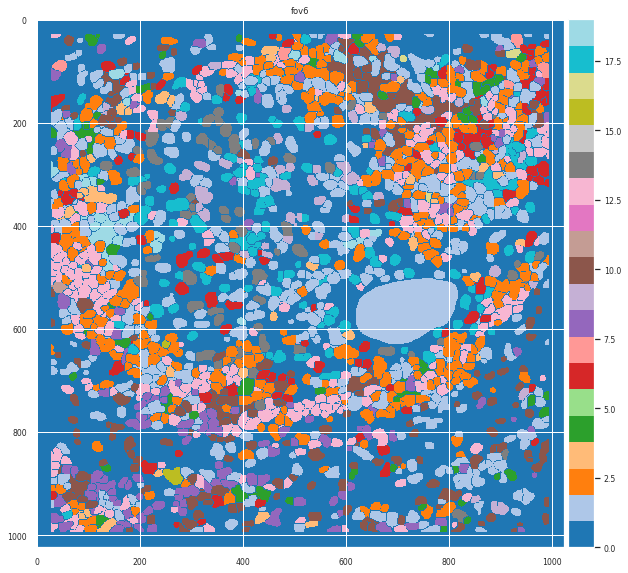

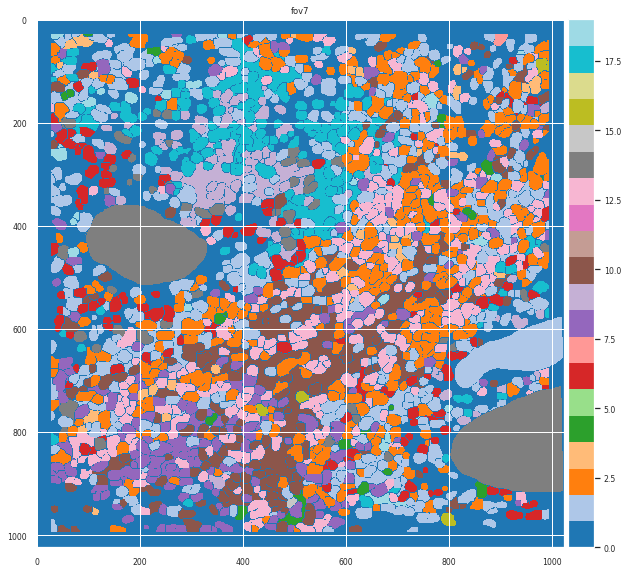

In [28]:
plot_utils.plot_clustering_result(
    cell_cluster_masks,
    cell_fovs
)